In [ ]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc

In [ ]:
# For inline plots in Jupyter Notebook
%matplotlib inline

In [ ]:
df = pd.read_csv('/content/Social Media Engagement Dataset.csv')

# Keep only text + sentiment
df_small = df[['text_content', 'sentiment_label']].copy()

# Drop missing or duplicate rows
df_small.dropna(subset=['text_content', 'sentiment_label'], inplace=True)
df_small.drop_duplicates(inplace=True)
df_small.reset_index(drop=True, inplace=True)

print("Shape:", df_small.shape)
print(df_small.head())
print("\nSentiment label distribution:")
print(df_small['sentiment_label'].value_counts())

Shape: (11997, 2)
                                        text_content sentiment_label
0  Just tried the Chromebook from Google. Best pu...        Positive
1  Just saw an ad for Microsoft Surface Laptop du...        Negative
2  What's your opinion about Nike's Epic React?  ...        Negative
3  Bummed out with my new Diet Pepsi from Pepsi! ...        Negative
4  Just tried the Corolla from Toyota. Absolutely...        Positive

Sentiment label distribution:
sentiment_label
Negative    4853
Positive    4837
Neutral     2307
Name: count, dtype: int64


In [ ]:
# Balance Classes by Resampling
def resample_data(df):
    max_count = df['sentiment_label'].value_counts().max()
    df_resampled = pd.DataFrame()

    for label in df['sentiment_label'].unique():
        df_class = df[df['sentiment_label'] == label]

        if len(df_class) < max_count:
            df_class_resampled = resample(
                df_class,
                replace=True,
                n_samples=max_count,
                random_state=42
            )
            df_resampled = pd.concat([df_resampled, df_class_resampled])
        else:
            df_resampled = pd.concat([df_resampled, df_class])

    return df_resampled.reset_index(drop=True)

# Apply to your filtered dataset
df_balanced = resample_data(df_small)

print("After resampling:")
print(df_balanced['sentiment_label'].value_counts())

After resampling:
sentiment_label
Positive    4853
Negative    4853
Neutral     4853
Name: count, dtype: int64


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_balanced['sentiment_encoded'] = le.fit_transform(df_balanced['sentiment_label'])

print(le.classes_)        # View label order
print(df_balanced.head()) # Preview

['Negative' 'Neutral' 'Positive']
                                        text_content sentiment_label  \
0  Just tried the Dri-FIT from Nike. Exceeded my ...        Positive   
1  Comparing Pepsi Pepsi Wild Cherry to the compe...        Positive   
2  Just saw an ad for Adidas Yeezy during the Sum...        Positive   
3  Frustrated with my new Galaxy S25 from Samsung...        Positive   
4  Toyota BlackFriday is excellent! Can't wait to...        Positive   

   sentiment_encoded  
0                  2  
1                  2  
2                  2  
3                  2  
4                  2  


In [ ]:

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

MAX_LEN = 128

# Use your balanced dataframe
df = df_balanced

# Prepare empty matrices
input_ids = np.zeros((len(df), MAX_LEN), dtype='int32')
attention_masks = np.zeros((len(df), MAX_LEN), dtype='int32')

def generate_bert_inputs(df, input_ids, attention_masks, tokenizer):
    for i, text in tqdm.tqdm(enumerate(df['text_content']), total=len(df)):
        tokenized = tokenizer.encode_plus(
            text,
            max_length=MAX_LEN,
            truncation=True,
            padding='max_length',
            add_special_tokens=True,
            return_tensors='np'
        )
        input_ids[i, :] = tokenized['input_ids']
        attention_masks[i, :] = tokenized['attention_mask']
    return input_ids, attention_masks

# Generate tokenized inputs
input_ids, attention_masks = generate_bert_inputs(df, input_ids, attention_masks, tokenizer)

print("input_ids shape:", input_ids.shape)
print("attention_masks shape:", attention_masks.shape)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

100%|██████████| 14559/14559 [00:10<00:00, 1442.06it/s]

input_ids shape: (14559, 128)
attention_masks shape: (14559, 128)


In [ ]:
# Use your balanced dataframe
df = df_balanced.copy()

# Convert sentiment labels to category codes (0,1,2,...)
df['sentiment_label'] = df['sentiment_label'].astype('category').cat.codes

# Number of classes (automatically detected)
num_classes = df['sentiment_label'].nunique()
print("Number of sentiment classes:", num_classes)

# One-hot encode labels
labels = np.zeros((len(df), num_classes), dtype='int32')
labels[np.arange(len(df)), df['sentiment_label'].values] = 1

# Build TF dataset
dataset = tf.data.Dataset.from_tensor_slices((input_ids, attention_masks, labels))

def to_dict(input_ids, masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': masks
    }, labels

dataset = dataset.map(to_dict)
dataset = dataset.shuffle(10000, seed=42).batch(32, drop_remainder=True)

print("Dataset ready!")

Number of sentiment classes: 3
Dataset ready!


In [ ]:
total_samples = len(df)   # df_balanced or df after preprocessing

# Create a shuffled index to ensure random distribution across splits
indices = np.arange(total_samples)
np.random.shuffle(indices)

# Apply shuffled indices to the data
input_ids_shuffled = input_ids[indices]
attention_masks_shuffled = attention_masks[indices]
labels_shuffled = labels[indices]

train_size = int(0.8 * total_samples)
val_size   = int(0.1 * total_samples)
test_size  = total_samples - train_size - val_size

print(train_size, val_size, test_size)

# Split shuffled numpy arrays
X_ids_train = input_ids_shuffled[:train_size]
X_mask_train = attention_masks_shuffled[:train_size]
y_train = labels_shuffled[:train_size]

X_ids_val = input_ids_shuffled[train_size:train_size+val_size]
X_mask_val = attention_masks_shuffled[train_size:train_size+val_size]
y_val = labels_shuffled[train_size:train_size+val_size]

X_ids_test = input_ids_shuffled[train_size+val_size:]
X_mask_test = attention_masks_shuffled[train_size+val_size:]
y_test = labels_shuffled[train_size+val_size:]

# Build datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_ids_train, X_mask_train, y_train)).map(to_dict).batch(32)
val_ds   = tf.data.Dataset.from_tensor_slices((X_ids_val, X_mask_val, y_val)).map(to_dict).batch(32)
test_ds  = tf.data.Dataset.from_tensor_slices((X_ids_test, X_mask_test, y_test)).map(to_dict).batch(32)


11647 1455 1457


In [ ]:
from transformers import TFBertModel
import tensorflow as tf

# Load BERT backbone
bert_model = TFBertModel.from_pretrained(
    'bert-base-uncased',
    force_download=False,
    use_safetensors=False
)

# Inputs
in_ids = tf.keras.layers.Input(shape=(MAX_LEN,), dtype='int32', name='input_ids')
in_mask = tf.keras.layers.Input(shape=(MAX_LEN,), dtype='int32', name='attention_mask')

# BERT forward pass
bert_outputs = bert_model(in_ids, attention_mask=in_mask)
sequence_output = bert_outputs.last_hidden_state   # shape: (batch, MAX_LEN, 768)

# BiLSTM layer (hybrid approach)
x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(
            64,
            return_sequences=False,
            dropout=0.2,
            recurrent_dropout=0.2
        )
    )(sequence_output)

# Dense layers
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)

# Output
out = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

# Build model
model = tf.keras.Model(inputs=[in_ids, in_mask], outputs=out)
model.summary()

# Optimizer
optim = tf.keras.optimizers.Adam(
    learning_rate=3e-5,   # smaller LR gives more stable training
    epsilon=1e-8
)

# Compile
model.compile(
    optimizer=optim,
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

# Callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    'hybrid_bert_bilstm.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    mode='min'
)

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[earlystop_cb, checkpoint_cb]
)


tf_model.h5:   0%|          | 0.00/536M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 128, 7                                       

364/364 [==============================] - ETA: 0s - loss: 0.3223 - accuracy: 0.8420
Epoch 1: val_loss improved from inf to 0.12944, saving model to hybrid_bert_bilstm.keras


/usr/local/lib/python3.12/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


364/364 [==============================] - 672s 2s/step - loss: 0.3223 - accuracy: 0.8420 - val_loss: 0.1294 - val_accuracy: 0.9299
Epoch 2/10
364/364 [==============================] - ETA: 0s - loss: 0.1142 - accuracy: 0.9366
Epoch 2: val_loss did not improve from 0.12944
364/364 [==============================] - 575s 2s/step - loss: 0.1142 - accuracy: 0.9366 - val_loss: 0.1295 - val_accuracy: 0.9162
Epoch 3/10
364/364 [==============================] - ETA: 0s - loss: 0.1097 - accuracy: 0.9389
Epoch 3: val_loss did not improve from 0.12944
364/364 [==============================] - 576s 2s/step - loss: 0.1097 - accuracy: 0.9389 - val_loss: 0.1295 - val_accuracy: 0.9175
Epoch 4/10
364/364 [==============================] - ETA: 0s - loss: 0.1105 - accuracy: 0.9344
Epoch 4: val_loss improved from 0.12944 to 0.12809, saving model to hybrid_bert_bilstm.keras
364/364 [==============================] - 611s 2s/step - loss: 0.1105 - accuracy: 0.9344 - val_loss: 0.1281 - val_accuracy: 0.92

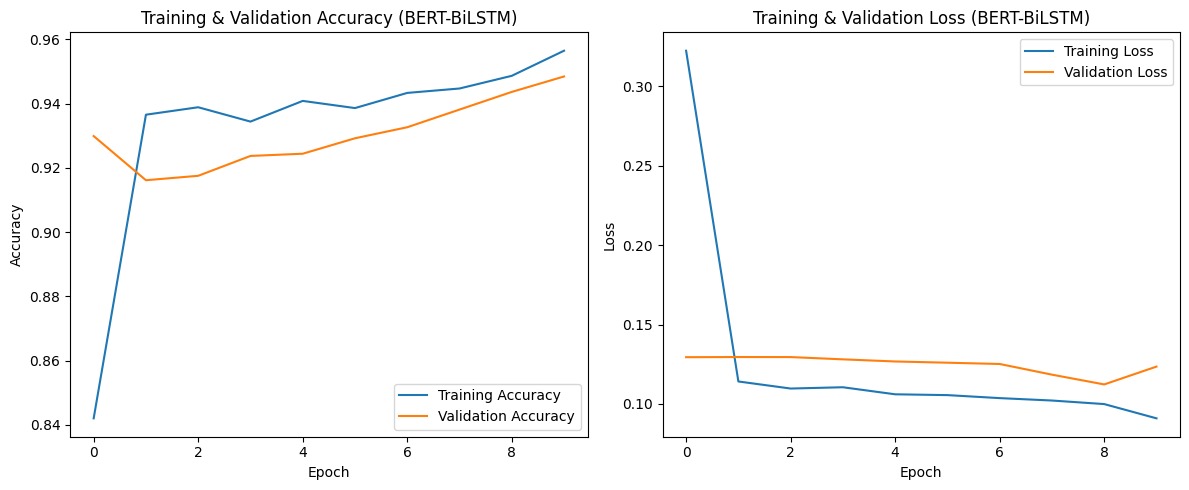

In [ ]:
import matplotlib.pyplot as plt

# Training Curves
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy (BERT-BiLSTM)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss (BERT-BiLSTM)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
# Load Best Model
from transformers import TFBertModel
model = tf.keras.models.load_model(
    'hybrid_bert_bilstm.keras',
    custom_objects={'TFBertModel': TFBertModel},
    compile=True
)


Evaluating on test set...

Test Loss : 0.1025
Test Accuracy : 0.9485 (94.85%)

Classification Report:
              precision    recall  f1-score   support

    Negative     0.9871    0.9018    0.9425       509
     Neutral     0.9251    0.9744    0.9491       469
    Positive     0.9357    0.9729    0.9539       479

    accuracy                         0.9485      1457
   macro avg     0.9493    0.9497    0.9485      1457
weighted avg     0.9503    0.9485    0.9484      1457



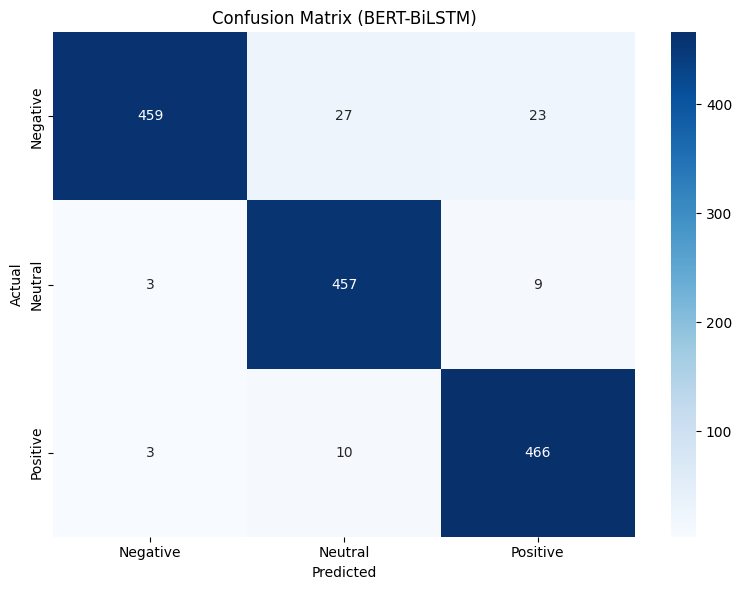

In [ ]:
# ============================
# Evaluation
# ============================

print("\nEvaluating on test set...")
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"\nTest Loss : {test_loss:.4f}")
print(f"Test Accuracy : {test_acc:.4f} ({test_acc * 100:.2f}%)")


statuses = ['Negative', 'Neutral', 'Positive']

# ============================
# Collect Predictions
# ============================

y_true_list = []

# Model.predict on the whole dataset (fast & vectorized)
all_probs = model.predict(test_ds, verbose=0)

# Extract true labels
for _, labels_onehot in test_ds:
    y_true_list.extend(np.argmax(labels_onehot.numpy(), axis=1))

y_true = np.array(y_true_list)
y_pred = np.argmax(all_probs, axis=1)

# ============================
# Classification Report
# ============================

print("\nClassification Report:")
print(classification_report(
    y_true,
    y_pred,
    target_names=statuses,
    digits=4,
    zero_division=0
))

# ============================
# Confusion Matrix
# ============================

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=statuses,
    yticklabels=statuses
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (BERT-BiLSTM)")
plt.tight_layout()
plt.show()


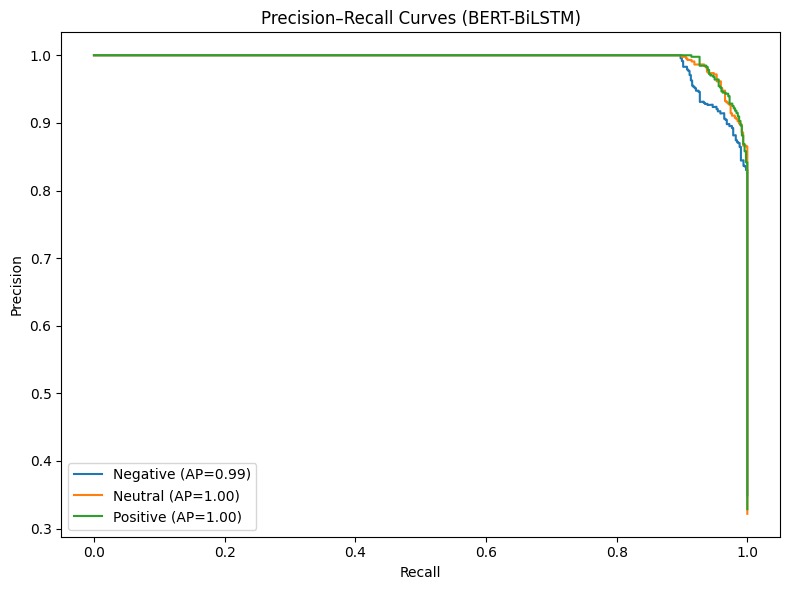

In [ ]:
# Binarize true labels for multi-class PR curves
n_classes = len(statuses)
y_true_binarized = label_binarize(y_true, classes=range(n_classes))

plt.figure(figsize=(8, 6))

for i, cls in enumerate(statuses):
    precision, recall, _ = precision_recall_curve(
        y_true_binarized[:, i],
        y_pred_probs[:, i]
    )

    ap = average_precision_score(
        y_true_binarized[:, i],
        y_pred_probs[:, i]
    )

    plt.plot(recall, precision, label=f'{cls} (AP={ap:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curves (BERT-BiLSTM)')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

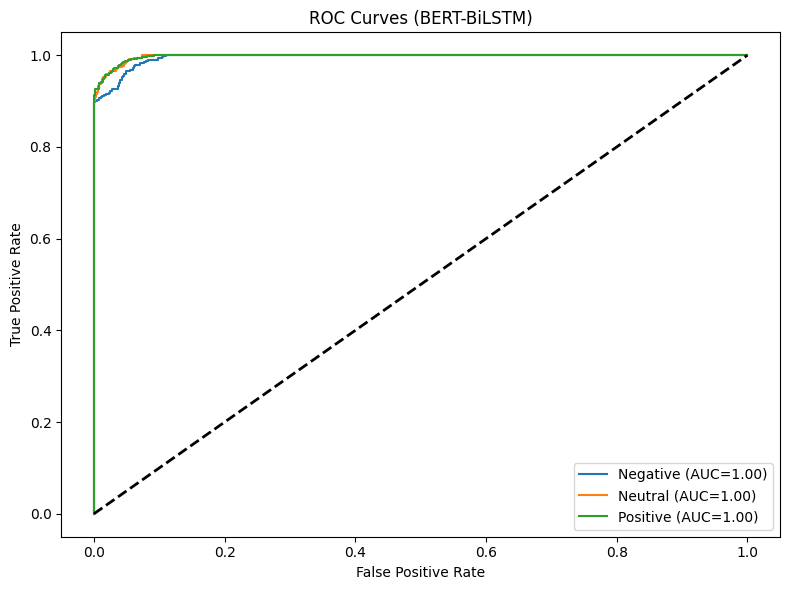

In [ ]:
# ROC Curves
plt.figure(figsize=(8, 6))
for i, cls in enumerate(statuses):
    fpr, tpr, _ = roc_curve(
        y_true_binarized[:, i], y_pred_probs[:, i]
    )
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{cls} (AUC={roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (BERT-BiLSTM)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()